In [32]:
import gc
import multiprocessing
from multiprocessing.pool import ThreadPool
import math
import os
import pathlib
import pickle
import random
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import dask
import dask.multiprocessing


from tqdm import tqdm_notebook
import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split

import lightgbm as lgb
import xgboost as xgb

import keras
from keras.models import Sequential
from keras.layers import Dense, CuDNNGRU
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed

In [2]:
%matplotlib inline

In [3]:
dask.config.set(scheduler='processes')
dask.set_options( pool=ThreadPool(10) )

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/dask/context.py:23: UserWarning: The dask.set_options function has been deprecated. Please use dask.config.set instead
  warnings.warn("The dask.set_options function has been deprecated. "


In [4]:
def add_features_dask_parralel(
#def add_features_parallel(
        df,
        input_first_index=None,
        input_last_index=None,
        sample_size=150000,
        holdout_size=50000,
        smootch_windows_size = (3, 5, 7)
    ):
    if input_first_index == None or input_last_index == None:
        input_first_index = df.index.min()
        input_last_index = df.index.max() + 1
        
    
    sample_indexes = random.sample(range(input_first_index, input_last_index), sample_size)
    sample_indexes.sort()
    
    smootch_feature_names = ['smootch_mean_ws_{}'.format(window_size) for window_size in smootch_windows_size]
    acoustic_data_series = df['acoustic_data']
    full_data_indexes = tuple(acoustic_data_series.index.tolist())

    sample_df = df.iloc[sample_indexes]

    sample_df.reset_index(inplace=True)
    sample_df.drop(columns=['index'], inplace=True)

    output_first_index = 0
    output_last_index = len(sample_df) - 1
    
    begin_indexes_set = set()
    end_indexes_set = set()
    
    start_time = time.time()
   
    sample_df_len = sample_df.shape[0]
    @dask.delayed
    def create_features():
        for window_size, feature_name in zip(smootch_windows_size, smootch_feature_names):

            feature_values_list = list(range(sample_size))

            half_window_size = window_size // 2

            sample_begin_indexes = sample_indexes[:half_window_size]
            full_data_begin_indexes = set(df.index[sample_begin_indexes].tolist())
            min_full_data_index = min(full_data_indexes)
        
            in_window_full_data_begin_indexes = set(range(input_first_index, input_first_index + half_window_size))              
            in_window_begin_indexes = full_data_begin_indexes.intersection(
                in_window_full_data_begin_indexes
            )
        
            sample_end_indexes = sample_indexes[-half_window_size:]
            full_data_end_indexes = set(df.index[sample_end_indexes].tolist())
            max_full_data_index = max(full_data_end_indexes) + 1
        
            in_window_full_data_end_indexes = set(range(input_last_index - half_window_size, input_last_index))        
            in_window_end_indexes = full_data_end_indexes.intersection(
                in_window_full_data_end_indexes
            )
            if in_window_begin_indexes:
                begin_indexes_set = begin_indexes_set.union(in_window_begin_indexes)
                for i, b_idx in enumerate(sorted(tuple(in_window_begin_indexes))):
                    value = sample_df.iloc[i]['acoustic_data']
                    temp = acoustic_data_series.iloc[input_first_index:input_first_index + window_size].mean()
                    value = value - temp
                    feature_values_list[output_first_index + i] = value
                
            if in_window_end_indexes:
                end_indexes_set = end_indexes_set.union(in_window_end_indexes)
                for i, e_idx in enumerate(sorted(tuple(in_window_end_indexes))):
                    value = sample_df.iloc[output_last_index - i]['acoustic_data']
                    temp = acoustic_data_series.iloc[input_last_index - window_size:].mean()
                    value = value - temp
                    feature_values_list[output_last_index - i] = value
                
            first_regular_idx = len(begin_indexes_set)
            last_regular_idx = sample_df_len - len(end_indexes_set)
            for i in range(first_regular_idx, last_regular_idx):
                sample_idx = sample_indexes[i]
                feature_values_list[i] = acoustic_data_series.iloc[
                    sample_idx - half_window_size:sample_idx + half_window_size
                ].mean()
            sample_df[feature_name] = feature_values_list
        return sample_df
      
    sample_df = create_features().compute()
    holdout_df = None
    if holdout_size > 0:
        holdout_indexes = np.random.randint(0, sample_df.shape[0], holdout_size)
        holdout_df = sample_df.iloc[holdout_indexes]
        holdout_df.reset_index(inplace=True)
        holdout_df.drop(columns=['index'], inplace=True)
        train_indexes = sorted(tuple(set(sample_df.index).difference(set(holdout_indexes))))
        sample_df = sample_df.iloc[train_indexes]
        sample_df.reset_index(inplace=True)
        sample_df.drop(columns=['index'], inplace=True)
    print("Full calculation feature value time (with slicing) {} min:".format((time.time() - start_time) / 60))
    return sample_df, holdout_df

In [5]:
add_features = add_features_dask_parralel

In [6]:
def add_features(
        df,
        input_first_index=None,
        input_last_index=None,
        sample_size=150000,
        holdout_size=50000,
        smootch_windows_size = (3, 5, 7)
    ):
    if input_first_index == None or input_last_index == None:
        input_first_index = df.index.min()
        input_last_index = df.index.max() + 1
        
    
    sample_indexes = random.sample(range(input_first_index, input_last_index), sample_size)
    sample_indexes.sort()
    
    smootch_feature_names = ['smootch_mean_ws_{}'.format(window_size) for window_size in smootch_windows_size]
    acoustic_data_series = df['acoustic_data']
    full_data_indexes = tuple(acoustic_data_series.index.tolist())

    sample_df = df.iloc[sample_indexes]

    sample_df.reset_index(inplace=True)
    sample_df.drop(columns=['index'], inplace=True)

    output_first_index = 0
    output_last_index = len(sample_df) - 1
    
    begin_indexes_set = set()
    end_indexes_set = set()
    
    start_time = time.time()
   
    sample_df_len = sample_df.shape[0]
    for window_size, feature_name in zip(smootch_windows_size, smootch_feature_names):

        feature_values_list = list(range(sample_size))

        half_window_size = window_size // 2

        sample_begin_indexes = sample_indexes[:half_window_size]
        full_data_begin_indexes = set(df.index[sample_begin_indexes].tolist())
        min_full_data_index = min(full_data_indexes)
        
        in_window_full_data_begin_indexes = set(range(input_first_index, input_first_index + half_window_size))              
        in_window_begin_indexes = full_data_begin_indexes.intersection(
            in_window_full_data_begin_indexes
        )
        
        sample_end_indexes = sample_indexes[-half_window_size:]
        full_data_end_indexes = set(df.index[sample_end_indexes].tolist())
        max_full_data_index = max(full_data_end_indexes) + 1
        
        in_window_full_data_end_indexes = set(range(input_last_index - half_window_size, input_last_index))        
        in_window_end_indexes = full_data_end_indexes.intersection(
            in_window_full_data_end_indexes
        )
        if in_window_begin_indexes:
            begin_indexes_set = begin_indexes_set.union(in_window_begin_indexes)
            for i, b_idx in enumerate(sorted(tuple(in_window_begin_indexes))):
                value = sample_df.iloc[i]['acoustic_data']
                temp = acoustic_data_series.iloc[input_first_index:input_first_index + window_size].mean()
                value = value - temp
                feature_values_list[output_first_index + i] = value
                
        if in_window_end_indexes:
            end_indexes_set = end_indexes_set.union(in_window_end_indexes)
            for i, e_idx in enumerate(sorted(tuple(in_window_end_indexes))):
                value = sample_df.iloc[output_last_index - i]['acoustic_data']
                temp = acoustic_data_series.iloc[input_last_index - window_size:].mean()
                value = value - temp
                feature_values_list[output_last_index - i] = value
                
        first_regular_idx = len(begin_indexes_set)
        last_regular_idx = sample_df_len - len(end_indexes_set)
        for i in range(first_regular_idx, last_regular_idx):
            sample_idx = sample_indexes[i]
            feature_values_list[i] = acoustic_data_series.iloc[
                sample_idx - half_window_size:sample_idx + half_window_size
            ].mean()
        sample_df[feature_name] = feature_values_list
        
    holdout_df = None
    if holdout_size > 0:
        holdout_indexes = np.random.randint(0, sample_df.shape[0], holdout_size)
        holdout_df = sample_df.iloc[holdout_indexes]
        holdout_df.reset_index(inplace=True)
        holdout_df.drop(columns=['index'], inplace=True)
        train_indexes = sorted(tuple(set(sample_df.index).difference(set(holdout_indexes))))
        sample_df = sample_df.iloc[train_indexes]
        sample_df.reset_index(inplace=True)
        sample_df.drop(columns=['index'], inplace=True)
    print("Full calculation feature value time (with slicing) {} min:".format((time.time() - start_time) / 60))
    return sample_df, holdout_df

In [7]:
def extract_features(z):
    print()
    print("extract_features, z.shape:", z.shape)
    #print()
    return np.c_[z.mean(axis=1),
                 np.transpose(np.percentile(np.abs(z), q=[0, 50, 75, 100], axis=1)),
                 z.std(axis=1)]

In [22]:
def extract_features(z):
    return np.c_[z.mean(axis=1),
                 np.transpose(np.percentile(np.abs(z), q=[0, 50, 75, 100], axis=1)),
                 z.std(axis=1)]

In [8]:
def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
    
    print("\n")
    print("createX, x.shape:", x.shape)
    print("createX, last_index:", last_index)
    print("createX, n_steps:", n_steps)
    print("createX, step_length:", step_length)
    print("last_index - n_steps * step_length:", last_index - n_steps * step_length)
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    # ORIGINAL: I changed this becuase I got an No OpKernel was registered to support Op 'CudnnRNN' error
    #temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    # MY CHANGE: This doesn't fix things, I get the same errors
    #temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1).astype(np.float32) - 5 ) / 3
    temp = x[(last_index - n_steps * step_length):last_index]
    print("createX, temp.shape before reshape:", temp.shape)
    temp = temp.reshape(n_steps, -1).astype(np.float32)
    print("create_X, temp.shape after reshape:", temp.shape)
    temp = (temp - 5) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations.
    print("createX, extract_features(temp).shape:", extract_features(temp).shape)
    print("createX, extract_features(temp[:, -step_length // 10:]).shape", extract_features(temp[:, -step_length // 10:]).shape)
    print("createX, extract_features(temp[:, -step_length // 100:]).shape", extract_features(temp[:, -step_length // 100:]).shape)
    print()
    result = np.c_[
        extract_features(temp),
        extract_features(temp[:, -step_length // 10:]),
        extract_features(temp[:, -step_length // 100:])
    ]
    '''               
    result = np.c_[
        temp,
        temp[:, -step_length // 10:],
        temp[:, -step_length // 100:]
    ]
    '''
    print("createX, result shape:", result.shape)
    print()
    '''
    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 10:]),
                 extract_features(temp[:, -step_length // 100:])]
    '''
    return result

In [24]:
def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
    
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    # ORIGINAL: I changed this becuase I got an No OpKernel was registered to support Op 'CudnnRNN' error
    #temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    # MY CHANGE: This doesn't fix things, I get the same errors
    #temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1).astype(np.float32) - 5 ) / 3
    temp = x[(last_index - n_steps * step_length):last_index]

    temp = temp.reshape(n_steps, -1).astype(np.float32)

    temp = (temp - 5) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations.

    result = np.c_[
        extract_features(temp),
        extract_features(temp[:, -step_length // 10:]),
        extract_features(temp[:, -step_length // 100:])
    ]

    return result

In [9]:
# The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
# the "time_to_failure" serves as target, while the features are created by the function "create_X".
#def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
def generator(data, y, rows, batch_size=16, n_steps=150, step_length=1000):
    #if max_index is None:
    #    max_index = len(data) - 1
    print("\n")   
    print("generator, data.shape:", data.shape)
    
    '''
    while True:
        # Pick indices of ending positions
        #rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
        print("generator, type(rows):", type(rows))
        print("generator, rows.shape:", rows.shape)
        print("generator rows:\n", rows)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        print("generator, samples.shape:", samples.shape)
        print("generator, targets.shape:", targets.shape)
        
        for j, row in enumerate(rows):
            print("generator j: {}, row: {}".format(j, row))
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            print("generator, samples[{}].shape:".format(j), samples[j].shape)
            print("generator, row - 1:", row - 1)
            targets[j] = data[row - 1, 1]
            print("generator, targets[{}].shape:".format(j), targets[j].shape)
            print()
        yield samples, targets
    '''
        
    while True:
        
        # Pick indices of ending positions
        #rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data, last_index=row, n_steps=n_steps, step_length=step_length)
            #targets[j] = data[row - 1, 1]
            targets[j] = y[row - 1]
            #temp = x[(last_index - n_steps * step_length):last_index]
            #print("createX, temp.shape before reshape:", temp.shape)
            #temp = temp.reshape(n_steps, -1).astype(np.float32)
            #print("create_X, temp.shape after reshape:", temp.shape)
            #temp = (temp - 5) / 3
        yield samples, targets

In [25]:
def generator(data, y, rows, batch_size=16, n_steps=150, step_length=1000):
    #if max_index is None:
    #    max_index = len(data) - 1

        
    while True:
        
        # Pick indices of ending positions
        #rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data, last_index=row, n_steps=n_steps, step_length=step_length)
            #targets[j] = data[row - 1, 1]
            targets[j] = y[row - 1]
        yield samples, targets

In [26]:
cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3)]

model = Sequential()
model.add(CuDNNGRU(48, input_shape=(None, n_features)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, 48)                9792      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                490       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 10,293
Trainable params: 10,293
Non-trainable params: 0
_________________________________________________________________


In [27]:
%%time
model.compile(optimizer=adam(lr=0.0005), loss="mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=30,
                              verbose=0,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200)



generator, data.shape: (1228017, 4)
CPU times: user 5h 22min 57s, sys: 1min 36s, total: 5h 24min 33s
Wall time: 5h 9min 53s


In [ ]:
#float_data = pd.read_csv("../input/train/train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values

In [10]:
%%time
#        earthquake_df = pd.read_csv(
#                '../input/train/train.csv',
#                #nrows=100000000,
#                names=['acoustic_data', 'time_to_failure'],
#                dtype={'acoustic_data': np.float32, 'time_to_failure': np.float32},
#                skiprows=earthquake_margin_indexes[i],
#                nrows=complete_earthquakes_length[i]
#            )

train_df = pd.read_csv('../input/train/train.csv', dtype={'acoustic_data': np.float32, 'time_to_failure': np.float32})

CPU times: user 2min 25s, sys: 12 s, total: 2min 37s
Wall time: 2min 55s


In [11]:
%%time
#        if not sample_size:
#            sample_size = complete_earthquakes_length[i] // 10
#        if not holdout_size:
#            holdout_size = complete_earthquakes_length[i] // 50
#sample_size = train_df.shape[0] // 10
#holdout_size = train_df.shape[0] // 50
sample_size = 7500000
holdout_size = 1500000
featured_train_df, featured_holdout_df = add_features(
                train_df,
                sample_size=sample_size,
                holdout_size=holdout_size
            )

Full calculation feature value time (with slicing) 84.39742310841878 min:
CPU times: user 1h 25min 13s, sys: 27.8 s, total: 1h 25min 41s
Wall time: 1h 25min 39s


In [12]:
featured_train_df.head()

,acoustic_data,time_to_failure,smootch_mean_ws_3,smootch_mean_ws_5,smootch_mean_ws_7
0,6.0,1.469100,7.0,5.50,6.000000
1,15.0,1.469100,11.5,10.75,9.500000
2,5.0,1.469099,3.5,3.25,2.666667
3,6.0,1.469099,8.0,7.75,6.166667
4,7.0,1.469099,7.0,7.00,6.000000


In [13]:
X_all = featured_train_df[featured_train_df.columns.drop('time_to_failure')]
y_all = featured_train_df['time_to_failure']

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, test_size=0.2, random_state=0)

In [19]:
train_rows = tuple(range(0, 4800000, 150000))[1:]
valid_rows = tuple(range(0, 1200000, 150000))[1:]
print(train_rows)
print(valid_rows)

(150000, 300000, 450000, 600000, 750000, 900000, 1050000, 1200000, 1350000, 1500000, 1650000, 1800000, 1950000, 2100000, 2250000, 2400000, 2550000, 2700000, 2850000, 3000000, 3150000, 3300000, 3450000, 3600000, 3750000, 3900000, 4050000, 4200000, 4350000, 4500000, 4650000)
(150000, 300000, 450000, 600000, 750000, 900000, 1050000)


In [16]:
# Query "create_X" to figure out the number of features
#n_features = create_X(float_data[0:150000]).shape[1]
n_features = create_X(X_train[0:150000].values).shape[1]
print("Our RNN is based on %i features"% n_features)



createX, x.shape: (150000, 4)
createX, last_index: 150000
createX, n_steps: 150
createX, step_length: 1000
last_index - n_steps * step_length: 0
createX, temp.shape before reshape: (150000, 4)
create_X, temp.shape after reshape: (150, 4000)

extract_features, z.shape: (150, 4000)
createX, extract_features(temp).shape: (150, 6)

extract_features, z.shape: (150, 100)
createX, extract_features(temp[:, -step_length // 10:]).shape (150, 6)

extract_features, z.shape: (150, 10)
createX, extract_features(temp[:, -step_length // 100:]).shape (150, 6)


extract_features, z.shape: (150, 4000)

extract_features, z.shape: (150, 100)

extract_features, z.shape: (150, 10)
createX, result shape: (150, 18)

Our RNN is based on 18 features


In [20]:
batch_size = 32

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
#second_earthquake = 50085877
#float_data[second_earthquake, 1]
#X_train[second_earthquake, 1]

# Initialize generators
# train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
# train_gen = generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)
# valid_gen = generator(float_data, batch_size=batch_size, max_index=second_earthquake)
train_gen = generator(X_train.values, y_train.values, train_rows, batch_size=batch_size)
valid_gen = generator(X_valid.values, y_valid.values, valid_rows, batch_size=batch_size)

In [21]:
train_gen.__next__()



generator, data.shape: (4912068, 4)


createX, x.shape: (4912068, 4)
createX, last_index: 150000
createX, n_steps: 150
createX, step_length: 1000
last_index - n_steps * step_length: 0
createX, temp.shape before reshape: (150000, 4)
create_X, temp.shape after reshape: (150, 4000)

extract_features, z.shape: (150, 4000)
createX, extract_features(temp).shape: (150, 6)

extract_features, z.shape: (150, 100)
createX, extract_features(temp[:, -step_length // 10:]).shape (150, 6)

extract_features, z.shape: (150, 10)
createX, extract_features(temp[:, -step_length // 100:]).shape (150, 6)


extract_features, z.shape: (150, 4000)

extract_features, z.shape: (150, 100)

extract_features, z.shape: (150, 10)
createX, result shape: (150, 18)



createX, x.shape: (4912068, 4)
createX, last_index: 300000
createX, n_steps: 150
createX, step_length: 1000
last_index - n_steps * step_length: 150000
createX, temp.shape before reshape: (150000, 4)
create_X, temp.shape after reshape: (150, 4000)

extract_


extract_features, z.shape: (150, 100)

extract_features, z.shape: (150, 10)
createX, result shape: (150, 18)



createX, x.shape: (4912068, 4)
createX, last_index: 2400000
createX, n_steps: 150
createX, step_length: 1000
last_index - n_steps * step_length: 2250000
createX, temp.shape before reshape: (150000, 4)
create_X, temp.shape after reshape: (150, 4000)

extract_features, z.shape: (150, 4000)
createX, extract_features(temp).shape: (150, 6)

extract_features, z.shape: (150, 100)
createX, extract_features(temp[:, -step_length // 10:]).shape (150, 6)

extract_features, z.shape: (150, 10)
createX, extract_features(temp[:, -step_length // 100:]).shape (150, 6)


extract_features, z.shape: (150, 4000)

extract_features, z.shape: (150, 100)

extract_features, z.shape: (150, 10)
createX, result shape: (150, 18)



createX, x.shape: (4912068, 4)
createX, last_index: 2550000
createX, n_steps: 150
createX, step_length: 1000
last_index - n_steps * step_length: 2400000
createX, temp.shape bef


extract_features, z.shape: (150, 100)

extract_features, z.shape: (150, 10)
createX, result shape: (150, 18)



createX, x.shape: (4912068, 4)
createX, last_index: 4500000
createX, n_steps: 150
createX, step_length: 1000
last_index - n_steps * step_length: 4350000
createX, temp.shape before reshape: (150000, 4)
create_X, temp.shape after reshape: (150, 4000)

extract_features, z.shape: (150, 4000)
createX, extract_features(temp).shape: (150, 6)

extract_features, z.shape: (150, 100)
createX, extract_features(temp[:, -step_length // 10:]).shape (150, 6)

extract_features, z.shape: (150, 10)
createX, extract_features(temp[:, -step_length // 100:]).shape (150, 6)


extract_features, z.shape: (150, 4000)

extract_features, z.shape: (150, 100)

extract_features, z.shape: (150, 10)
createX, result shape: (150, 18)



createX, x.shape: (4912068, 4)
createX, last_index: 4650000
createX, n_steps: 150
createX, step_length: 1000
last_index - n_steps * step_length: 4500000
createX, temp.shape bef

(array([[[-0.19120835,  0.        ,  0.66666669, ...,  3.66666675,
           4.08333349,  1.63776803],
         [-0.10288889,  0.        ,  0.66666669, ...,  1.06250003,
           1.5       ,  0.73864347],
         [-0.14128472,  0.        ,  0.66666669, ...,  1.09722218,
           1.5       ,  0.78963679],
         ...,
         [-0.09711111,  0.        ,  0.66666669, ...,  0.62500001,
           1.11111116,  0.48464859],
         [-0.28977081,  0.        ,  0.66666669, ...,  1.04166664,
           1.66666663,  0.86270463],
         [-0.10181945,  0.        ,  0.66666669, ...,  0.66666669,
           1.08333337,  0.65216291]],
 
        [[-0.17263888,  0.        ,  0.66666669, ...,  0.54166664,
           0.83333331,  0.47369868],
         [-0.250375  ,  0.        ,  0.58333331, ...,  1.        ,
           1.16666663,  0.39166665],
         [-0.17546527,  0.        ,  0.6111111 , ...,  4.37499976,
           5.        ,  2.06230307],
         ...,
         [-0.19015972,  0.       

In [29]:
featured_holdout_df.head()

,acoustic_data,time_to_failure,smootch_mean_ws_3,smootch_mean_ws_5,smootch_mean_ws_7
0,7.0,0.582099,8.5,7.75,7.500000
1,3.0,10.564999,6.0,6.25,5.333333
2,2.0,0.320900,4.0,3.75,4.333333
3,2.0,2.599000,4.5,4.00,4.833333
4,15.0,3.518199,11.5,12.50,12.833333


In [30]:
holdout_prediction = model.predict(featured_holdout_df[featured_holdout_df.columns.drop('acoustic_data')])

ValueError: Error when checking input: expected cu_dnngru_1_input to have 3 dimensions, but got array with shape (1500000, 4)

In [ ]:
model.compile(optimizer=adam(lr=0.0005), loss="mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=30,
                              verbose=0,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200)

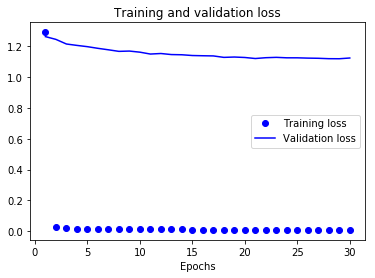

In [28]:
def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

perf_plot(history)

In [34]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

In [36]:
for i, seg_id in enumerate(tqdm_notebook(submission.index)):
  #  print(i)
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    submission.time_to_failure[i] = model.predict(np.expand_dims(create_X(x), 0))

submission.head()

,time_to_failure
seg_id,
seg_00030f,3.775189
seg_0012b5,3.561212
seg_00184e,3.827060
seg_003339,3.929479
seg_0042cc,3.956853


In [37]:
submission.to_csv('submission_rnn_smoothing.csv')

In [38]:
s_rnn_s = pd.read_csv('submission_rnn_smoothing.csv')
s_base = pd.read_csv('submission_chunks_10.csv')
s_rnn_base = pd.read_csv('rnn-submission.csv')

In [39]:
mean_absolute_error(s_base['time_to_failure'], s_rnn_base['time_to_failure'])

4.017881146654393

In [40]:
mean_absolute_error(s_base['time_to_failure'], s_rnn_s['time_to_failure'])

0.9916080741280486

In [42]:
mean_absolute_error(s_rnn_base['time_to_failure'], s_rnn_s['time_to_failure'])

3.6419703508384154